In [1]:
print("ok all")

ok all


In [2]:
import os,sys
projject_root = os.path.abspath(os.path.join(os.getcwd(),".."))
sys.path.append(projject_root)

print(projject_root)

d:\Sunny_savitha\auto_rec\automated-research-report-generation


In [3]:
from research_and_analysts.utils.model_loader import ModelLoader


In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-10-27T01:11:16.606200Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T01:11:16.614674Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T01:11:16.614674Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-27T01:11:16.614674Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-27T01:11:16.614674Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-27T01:11:16.628655Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm = model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-10-27T01:11:16.651252Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("Hi").content

'Hi there! How can I help you today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from IPython.display import Image, display

In [9]:
class Analyst(BaseModel):
    name:str = Field(description="Name of analyst.")
    role:str = Field(description="Role of analyst in context of topic")
    affiliation:str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Description of the analyst focus, concerns and motives.")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
analyst = Analyst(
    name="Munavar",
    role="gen_ai eng",
    affiliation="AI Research Lab",
    description="I am genai eng"
)

In [11]:
analyst.name

'Munavar'

In [12]:
print(analyst.persona)

Name: Munavar
Role: gen_ai eng
Affiliation: AI Research Lab
Description: I am genai eng



In [13]:
class Perspective(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analyst with theor roles and affiliations.")

In [14]:
class GenerativeAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback:str
    analysts: List[Analyst]

In [15]:
GenerativeAnalystState(
    topic= "finance",
    max_analysts= 5,
    human_analyst_feedback="Give the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'}

In [16]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [84]:
def create_analyst(state:GenerativeAnalystState):
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    structured_llm = llm.with_structured_output(Perspective)
    system_message = analyst_instructions.format(
        topic = topic,
        max_analysts=max_analysts,
        human_analyst_feedback = human_analyst_feedback
    )
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analyst. ")])
    return {"analysts": analysts.analysts}

In [ ]:
create_analyst(
 {'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'})

{'analysts': [Analyst(name='Ava Sterling', role='Quantitative Analyst', affiliation='Hedge Fund X', description='Focuses on statistical modeling and algorithmic trading strategies to maximize returns and manage risk. Concerned with market volatility and data accuracy.'),
  Analyst(name='Ben Carter', role='Financial Regulation Specialist', affiliation='Regulatory Compliance Agency', description='Monitors financial institutions for compliance with regulations, aiming to prevent fraud and maintain market stability. Motivated by protecting investors and the integrity of the financial system.'),
  Analyst(name='Chloe Davis', role='Investment Strategist', affiliation='Global Investment Bank Y', description='Develops investment strategies based on macroeconomic trends and company performance. Aims to identify growth opportunities and manage portfolio risk. Driven by delivering consistent returns to clients.'),
  Analyst(name='David Lee', role='Corporate Finance Advisor', affiliation='Mergers 

In [19]:
def human_feedback(state):
    pass

In [20]:
def should_continue(state):
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analyst"

In [21]:
builder = StateGraph(GenerativeAnalystState)

In [22]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [23]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",
                         should_continue,
                         ["create_analyst",
                          END])

In [24]:
memory = MemorySaver()

In [25]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer = memory)

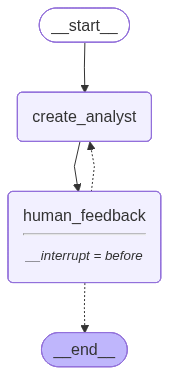

In [26]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [27]:
topic = "the benefits of adopting Langgraph as agent framework"
max_analysts = 4
thread = {"configurable":{"thread_id":1}}

In [28]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.
--------------------------------------------------
Name: Bob Garcia
Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research.
--------------------------------------------------
Name: Charlie Lee
Affiliation: Global Corp
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective, focusing on its potential to improve existing AI 

In [29]:
state = graph.get_state(thread)

In [30]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Thompson', role='AI Infrastructure Engineer', affiliation='Tech Solutions Inc.', description='Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.'), Analyst(name='Bob Garcia', role='AI Research Scientist', affiliation='Innovation Lab', description="Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research."), Analyst(name='Charlie Lee', role='AI Product Manager', affiliation='Global Corp', description='Evaluates Langgraph from a prod

In [31]:
graph.update_state(thread,{"human_analyst_feedback":"add something from the startup perspective and focus on "}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2d1d-df61-6003-8002-1ff13bbc6a3b'}}

In [32]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.


Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.
--------------------------------------------------
Name: Bob Garcia
Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research.
--------------------------------------------------
Name: Charlie Lee
Affiliation: Global Corp
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective, focusing on its potential to improve existing AI products and create new ones. Concerned with user expe

In [33]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on ', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='Early-Stage Startup', description="Focuses on rapid prototyping and deployment. Concerned with minimizing infrastructure costs and maximizing developer velocity. Interested in Langgraph's ability to quickly iterate on agent workflows and its low barrier to entry."), Analyst(name='Ben Carter', role='AI Research Scientist', affiliation='Academic Institution', description="Interested in the theoretical implications of Langgraph. Focuses on its ability to model complex agent interactions and its potential for formal verification.  Concerned with the framework's expressiveness and its ability to capture nuanced agent behaviors."), Analyst(name='Priya Sharma', role='Enterprise Architect', affiliation='Large Corporation', description

In [34]:
state.next

('human_feedback',)

In [35]:
further_feedback = "None"
graph.update_state(thread,{"human_analyst_feedback":further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2d1e-0090-60f4-8006-d5d832caa15b'}}

In [36]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [37]:
final_state.next

('create_analyst',)

## Second Workflow

In [38]:
import os
from dotenv import load_dotenv
load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")


In [39]:
from langchain_community.tools import TavilySearchResults
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

tavily_search.invoke("LLM")


C:\Users\bsmun\AppData\Local\Temp\ipykernel_17524\3464101177.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


[{'title': 'Large language model - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Large_language_model',
  'content': 'A large language model (LLM) is a language model trained with self-supervised machine learning on a vast amount of text, designed for natural language processing tasks, especially language generation. The largest and most capable LLMs are generative pre-trained transformers (GPTs) and provide the core capabilities of chatbots such as ChatGPT, Gemini "Gemini (chatbot)") and Claude "Claude (language model)"). LLMs can be fine-tuned "Fine-tuning (deep learning)") for specific tasks or guided by [...] An LLM is a type of foundation model (large X model) trained on language. LLMs can be trained in different ways. In particular, GPT models are first pretrained to predict the next word on a large amount of data, before being fine-tuned.[citation needed]\n\n### Cost\n\n[edit] [...] They consist of billions to trillions of parameters and operate as general-purpose sequence

In [40]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [41]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrival")

In [42]:
def _state_map(state):
    """Return a dict-like mapping for the provided state.
    Accepts dicts, Pydantic v2 model instances (model_dump), Pydantic v1 (dict),
    or falls back to __dict__.
    """
    if isinstance(state, dict):
        return state
    # Pydantic v2
    if hasattr(state, "model_dump"):
        try:
            return state.model_dump()
        except Exception:
            pass
    # Pydantic v1
    if hasattr(state, "dict"):
        try:
            return state.dict()
        except Exception:
            pass
    # fallback: try __dict__ or return original
    return getattr(state, "__dict__", state)


In [43]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [44]:
print(analyst.persona)

Name: David Lee
Role: AI Product Manager
Affiliation: Technology Company
Description: Focuses on the practical applications of Langgraph and its ability to solve real-world problems. Concerned with its ease of use and its ability to be customized for specific use cases. Interested in its potential for creating innovative AI products and services.



In [45]:
def generation_question(state:InterviewState):
    m = _state_map(state)
    analyst = m.get("analyst")
    messages = m.get("messages", [])

    system_messages = question_instructions.format(goals = analyst.persona if analyst is not None else "")
    question = llm.invoke([SystemMessage(content=system_messages)]+messages)

    return {"messages":[question]}


In [46]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], "messages":[HumanMessage(content="hi do the proper research according to the expertises")]}

In [47]:
result = generation_question(state)
print(result["messages"][0].content)

Okay, here we go.

Hello David, my name is Anya Sharma, and I'm an analyst focusing on the practical applications of AI. I'm particularly interested in Langgraph and its potential to move beyond theoretical applications and solve real-world problems.

Given your experience as an AI Product Manager, I'm hoping you can provide some specific insights into how Langgraph is being used, or *could* be used, to create tangible value.

To start, what's the most *interesting* or *surprising* application of Langgraph you've come across, something that really made you think, "Wow, this is a game-changer"? I'm not necessarily looking for the *most* impactful, but the one that sparked the most creative thinking for you.


In [48]:
print(result) 

{'messages': [AIMessage(content='Okay, here we go.\n\nHello David, my name is Anya Sharma, and I\'m an analyst focusing on the practical applications of AI. I\'m particularly interested in Langgraph and its potential to move beyond theoretical applications and solve real-world problems.\n\nGiven your experience as an AI Product Manager, I\'m hoping you can provide some specific insights into how Langgraph is being used, or *could* be used, to create tangible value.\n\nTo start, what\'s the most *interesting* or *surprising* application of Langgraph you\'ve come across, something that really made you think, "Wow, this is a game-changer"? I\'m not necessarily looking for the *most* impactful, but the one that sparked the most creative thinking for you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--5a060d96-0f49-45d0-93f1-4f192b3fdf14-0', us

In [49]:
from langchain_core.messages import get_buffer_string
search_instruction = SystemMessage(
    content="""
You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query
"""
)

In [50]:
def search_web(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}



In [51]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], 'messages': [AIMessage(content='Okay, here we go.\n\nHello David, my name is Anya Sharma, and I\'m an analyst focusing on the practical applications of AI. I\'m particularly interested in Langgraph and its potential to move beyond theoretical applications and solve real-world problems.\n\nGiven your experience as an AI Product Manager, I\'m hoping you can provide some specific insights into how Langgraph is being used, or *could* be used, to create tangible value.\n\nTo start, what\'s the most *interesting* or *surprising* application of Langgraph you\'ve come across, something that really made you think, "Wow, this is a game-changer"? I\'m not necessarily looking for the *most* impactful, but the one that sparked the most creative thinking for you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--34bae306-f359-454f-a007-d6bb515ef6ce-0', usage_metadata={'input_tokens': 233, 'output_tokens': 163, 'total_tokens': 396, 'input_token_details': {'cache_read': 0}})]}

In [52]:
result = search_web(state)

In [53]:
result['context'][0]

'<Document href="https://www.linkedin.com/pulse/exploring-frontiers-ai-top-5-use-cases-langchain-dileep-kumar-pandiya-hos3e"/>\nLangGraph Enhancement: LangGraph can be used to implement more complex document processing pipelines. For example, different nodes in the graph can be responsible for different tasks, such as text cleaning, chunking, and summarization. This allows for more modular and efficient processing of large document sets. [...] LangGraph Enhancement: LangGraph can be used to implement more complex data analysis pipelines. For example, different nodes in the graph can be responsible for different data processing steps, such as cleaning, transforming, and aggregating data. [...] LangGraph Enhancement: LangGraph can be used to implement more complex code generation workflows. For instance, different nodes in the graph can be responsible for generating different parts of the code, allowing for modular and collaborative code development.\n</Document>\n\n---\n\n<Document href

In [54]:
print(result)

{'context': ['<Document href="https://www.linkedin.com/pulse/exploring-frontiers-ai-top-5-use-cases-langchain-dileep-kumar-pandiya-hos3e"/>\nLangGraph Enhancement: LangGraph can be used to implement more complex document processing pipelines. For example, different nodes in the graph can be responsible for different tasks, such as text cleaning, chunking, and summarization. This allows for more modular and efficient processing of large document sets. [...] LangGraph Enhancement: LangGraph can be used to implement more complex data analysis pipelines. For example, different nodes in the graph can be responsible for different data processing steps, such as cleaning, transforming, and aggregating data. [...] LangGraph Enhancement: LangGraph can be used to implement more complex code generation workflows. For instance, different nodes in the graph can be responsible for generating different parts of the code, allowing for modular and collaborative code development.\n</Document>\n\n---\n\n<

In [55]:
def search_wikipedia(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    print("*******************************")
    print(search_query)

    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context":[formatted_search_docs]}

In [56]:
search_wikipedia(state)

*******************************
search_query='most interesting or surprising applications of Langgraph'


{'context': ['']}

In [57]:
result = search_web(state)

In [58]:
print(result)

{'context': ['<Document href="https://www.linkedin.com/pulse/exploring-frontiers-ai-top-5-use-cases-langchain-dileep-kumar-pandiya-hos3e"/>\nLangGraph Enhancement: LangGraph can be used to implement more complex document processing pipelines. For example, different nodes in the graph can be responsible for different tasks, such as text cleaning, chunking, and summarization. This allows for more modular and efficient processing of large document sets. [...] LangGraph Enhancement: LangGraph can be used to implement more complex data analysis pipelines. For example, different nodes in the graph can be responsible for different data processing steps, such as cleaning, transforming, and aggregating data. [...] LangGraph Enhancement: LangGraph can be used to implement more complex code generation workflows. For instance, different nodes in the graph can be responsible for generating different parts of the code, allowing for modular and collaborative code development.\n</Document>\n\n---\n\n<

In [59]:
answer_instruction="""You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [60]:
def generate_answer(state:InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instruction.format(goals=analyst.persona,context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "expert"

    return {"messages":[answer]}

In [61]:
def route_messages(state:InterviewState, name:str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)
    num_responses = len([m for m in messages if isinstance(m,AIMessage) and m.name==name])

    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question:
        return 'save_interview'
    
    return "ask_question"




In [62]:
def save_interview(state:InterviewState):
    messages = state["messages"]

    interview = get_buffer_string(messages)

    return {"interview":interview}



In [63]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [64]:
def write_section(state:InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    return {"sections":[section.content]}

In [65]:
interview_builder = StateGraph(InterviewState)

In [66]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [67]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question","save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [68]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

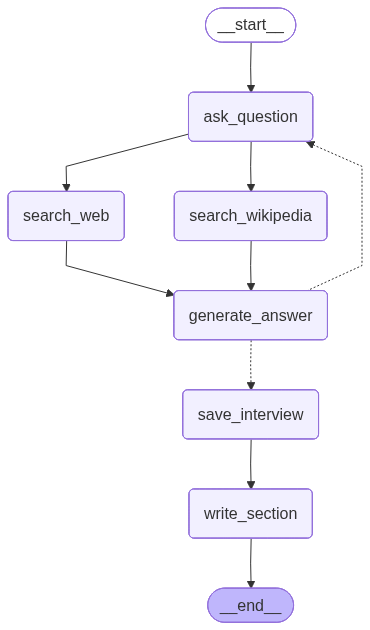

In [69]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [70]:
analyst.persona

'Name: David Lee\nRole: AI Product Manager\nAffiliation: Technology Company\nDescription: Focuses on the practical applications of Langgraph and its ability to solve real-world problems. Concerned with its ease of use and its ability to be customized for specific use cases. Interested in its potential for creating innovative AI products and services.\n'

In [81]:
from IPython.display import Markdown
messages = [HumanMessage("So you said you are writing an article on MCP")]

thread = {"configurable": {"thread_id": "1"}}

In [82]:
interview = interview_graph.invoke({
    "analyst":analyst, 
    "messages":messages,
    "max_num_turns":2, 
    "section": [],  
    "interview": "" },thread)

*******************************
search_query='LangGraph use cases and benefits'


In [ ]:
print('section (singular):', interview.get('section'))

section (singular): None


In [75]:
type(interview)

dict

In [80]:
for i,j in interview.items():
    print(i, ":", j)

messages : [HumanMessage(content='So you said you are writing an article on langgraph', additional_kwargs={}, response_metadata={}, id='76da4edb-fa18-4108-bbae-f9a8c088c89c'), AIMessage(content='Hi David, thanks for taking the time to chat. I\'m Alex, an analyst working on understanding the practical applications of LangGraph. I\'m particularly interested in identifying the "aha!" moments – the surprising or non-obvious ways people are using it to solve real-world problems.\n\nTo kick things off, you mentioned you\'re writing an article on LangGraph. What\'s the core message you\'re hoping to convey? What\'s the one thing you want readers to take away about its capabilities and potential?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--fc3c59d0-6583-40a7-9a59-72a3801c8e17-0', usage_metadata={'input_tokens': 233, 'output_tokens': 109, 'total

In [77]:
Markdown(interview['sections'][0])

## LangGraph: A Practical Solution for Building Sophisticated AI Applications

### Summary

LangGraph is a framework designed to simplify the development of complex AI applications by providing a structured approach to orchestrating Large Language Models (LLMs). Unlike LangChain, which excels in linear workflows, LangGraph uses a graph-based architecture to manage non-linear, stateful, and multi-agent systems [2]. This allows developers to create more sophisticated AI models that can learn and improve over time [1]. LangGraph's ability to manage state, support human-in-the-loop interactions, and handle intricate decision-making processes makes it a valuable tool for building advanced AI solutions [2, 5, 9].

LangGraph's key features include a directed graph for orchestrating autonomous workflows, state management for long-running processes and error recovery, and support for human intervention [2]. The framework allows developers to define a state object that is updated as the workflow progresses, providing granular control and enabling the persistence of data such as conversation history and task lists across sessions [4]. This is particularly useful for applications requiring long-term memory and the ability to resume interrupted processes [4, 8].

The framework's graph structure offers flexibility in workflow design, while its state management capabilities ensure that context is maintained throughout the process [9]. LangGraph also supports real-time streaming, persistence, and human-in-the-loop checks, making it suitable for real-world, error-tolerant systems [9]. Furthermore, LangGraph is designed to work with LangChain, allowing developers to use LangChain's modular components within LangGraph nodes [4]. This combination provides the best of both worlds: LangChain's building blocks and LangGraph's advanced orchestration capabilities [4].

LangGraph is being used in various applications, including conversational AI, agent systems, and personalized experiences [1, 3, 5]. For example, Norwegian Cruise Line uses LangGraph to develop guest-facing AI solutions that improve and personalize guest interactions [1]. Additionally, services like Google’s Duplex utilize LangGraph to mimic human-like conversations [1]. By providing a modular and flexible framework, LangGraph enables developers to create context-aware and automated systems that can transform how AI applications are built [3].

### Sources

[1] https://www.ibm.com/think/topics/langgraph
[2] https://medium.com/@martin.hodges/how-to-create-an-agentic-ai-application-using-langgraph-f384128fce90
[3] https://www.linkedin.com/pulse/exploring-frontiers-ai-top-5-use-cases-langchain-dileep-kumar-pandiya-hos3e
[4] https://duplocloud.com/blog/langchain-vs-langgraph/
[5] https://medium.com/@saimoguloju2/langgraph-building-intelligent-multi-agent-workflows-with-state-management-0427264b6318
[6] https://activewizards.com/blog/mastering-langgraph-a-guide-to-stateful-ai-workflows
[7] https://blog.langchain.com/building-langgraph/
[8] https://langchain-ai.github.io/langgraph/guides/
[9] https://www.designveloper.com/blog/what-is-langgraph/
[10] https://blog.langchain.com/langgraph/

## Third Workflow

In [ ]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState:
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str



In [ ]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback",human_feedback)
builder.add_node("conduct_interview",interview_builder.compile())
builder.add_node("write_report", write_report)
